In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, precision_recall_curve, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
from scipy.stats import pointbiserialr
from sklearn import tree

## Load Datasets# 

In [2]:
train_dt = pd.read_csv('train.csv')
test_dt = pd.read_csv('test.csv')

In [3]:
train_dt

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## Helper Functions

In [4]:
def cramers_corrected_stat(train_dt,chi_test_stats,crosstab):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    n = len(train_dt)
    phi = chi_test_stats/n
    r,k = crosstab.shape    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    #print(n,phi,r,k)
    return np.sqrt(phi / min( (kcorr-1), (rcorr-1)))

## Exploratory Data Analysis

### What is the shape of the datasets?

In [5]:
print('Shape of train dataset:',train_dt.shape)
print('Shape of test dataset:',test_dt.shape)

Shape of train dataset: (891, 12)
Shape of test dataset: (418, 11)


### Details of the fields (Name, Datatypes)

In [6]:
train_dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Observations:
1. Categorical Features : Embarked, Sex, PClass, Parch, SibSp
2. Numerical Features: Fare, Age
3. Alphanumeric/string: Name, Cabin, Ticket

### Features having missing values

In [7]:
train_dt.columns[train_dt.isnull().any()]

Index(['Age', 'Cabin', 'Embarked'], dtype='object')

###  Class Distribution 

In [8]:
round(train_dt.groupby(by=['Survived'])['PassengerId'].count()/len(train_dt)*100)

Survived
0    62.0
1    38.0
Name: PassengerId, dtype: float64

### Some Assumptions:
1. Females had more survival chances. 
2. Survival rate changes with respect to the passenger class. 

### Sex: 

1. What is the distribution? 

In [9]:
round(train_dt.groupby(by=['Sex'])['PassengerId'].count()/len(train_dt)*100)

Sex
female    35.0
male      65.0
Name: PassengerId, dtype: float64

2. What is survival percentage of each gender ? 

In [10]:
train_dt[train_dt['Survived']==1].groupby(by=['Sex'])['PassengerId'].count()/len(train_dt)*100

Sex
female    26.150393
male      12.233446
Name: PassengerId, dtype: float64

3. Barplot of Survival and Sex

In [11]:
grp_dt = train_dt[['Sex','Survived','PassengerId']].groupby(by=['Sex','Survived']).count().reset_index()
grp_dt

,Sex,Survived,PassengerId
0,female,0,81
1,female,1,233
2,male,0,468
3,male,1,109


Text(0, 0.5, 'Frequency')

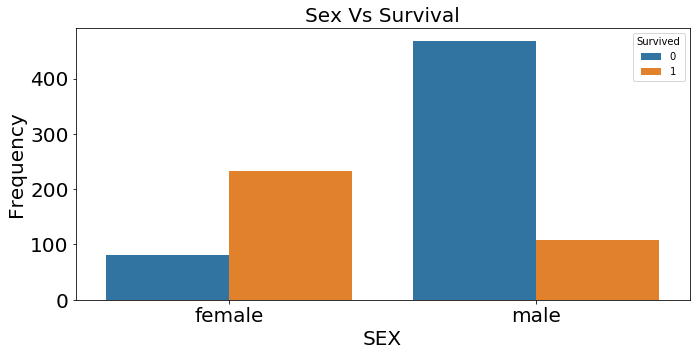

In [12]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x='Sex',y='PassengerId',hue='Survived', data=grp_dt, ci=False)
ax.set_title('Sex Vs Survival',fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('SEX', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

<div class='alert alert-block alert-info'>
    <p>Interestingly, only <b>12%</b> male survived out of <b>65%</b> which means <b>53%</b> male couldn't survived in this tragic incident whereas, there is only <b>9%</b> females who died in this incident but the majority of the females survived that is <b>26%</b>. Hence we can say <b>Sex</b> can be a good predictor  </p>
</div>

4. Coorelation of Sex With Survival. 

In [13]:
sexCrossTab = pd.crosstab(train_dt['Sex'],train_dt['Survived'])#,margins=True)
sexCrossTab

Survived,0,1
Sex,,
female,81,233
male,468,109


In [14]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(sexCrossTab)

In [15]:
contigencyTab

array([[193.47474747, 120.52525253],
       [355.52525253, 221.47474747]])

In [16]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 260.71702016732104 P-Value 1.1973570627755645e-58


In [17]:
cramers_corrected_stat(train_dt,testStatistic,sexCrossTab)

0.5412400963770316

<div class='alert alert-block alert-info'>
    <p>Crammer'V and chi square statistics confirm our assumption that Sex is one of the decisive feature in this problem and the coorelation is reasonable (not too weak not too strong) </p>
</div>

### Passenger Class: 

1. What is the distribution?

In [18]:
train_dt.groupby(by=['Pclass'])['PassengerId'].count()/len(train_dt)*100

Pclass
1    24.242424
2    20.650954
3    55.106622
Name: PassengerId, dtype: float64

2. What is the survival percentage in each class of passenger?

In [19]:
train_dt[train_dt['Survived']==1].groupby(by=['Pclass'])['PassengerId'].count()/len(train_dt)*100

Pclass
1    15.263749
2     9.764310
3    13.355780
Name: PassengerId, dtype: float64

3. Barplot of Survival and Passenger Class

In [20]:
grp_dt = train_dt[['Pclass','Survived','PassengerId']].groupby(by=['Pclass','Survived']).count().reset_index()
grp_dt

,Pclass,Survived,PassengerId
0,1,0,80
1,1,1,136
2,2,0,97
3,2,1,87
4,3,0,372
5,3,1,119


Text(0, 0.5, 'Frequency')

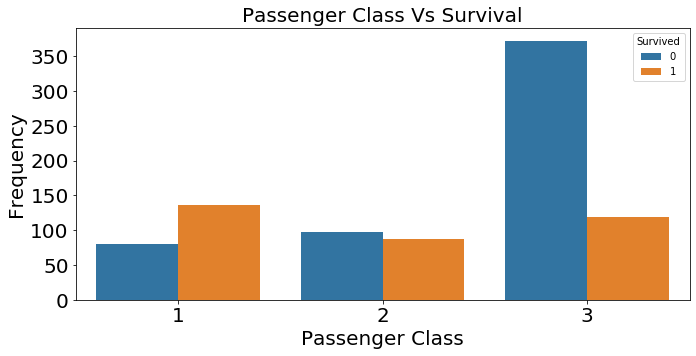

In [21]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x='Pclass',y='PassengerId',hue='Survived', data=grp_dt, ci=False)
ax.set_title('Passenger Class Vs Survival',fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('Passenger Class', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

<div class='alert alert-block alert-info'>
    <p> It seems like Passenger class has significant impact on survival. The percentage difference between those who survived and those couldn't is huge in 3rd class of the passengers. Interestingly only in 1st class of passenger the number of survival are more than number of died  </p>
</div>

4. Coorelation of Passenger Class With Survival. 

In [22]:
PclassCrossTab = pd.crosstab(train_dt['Pclass'],train_dt['Survived'])

In [23]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(PclassCrossTab)

In [24]:
PclassCrossTab

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


In [25]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 102.88898875696056 P-Value 4.549251711298793e-23


In [26]:
cramers_corrected_stat(train_dt,testStatistic,PclassCrossTab)

0.3400084576791133

<div class='alert alert-block alert-info'>
    <p>Crammer'V and chi square statistics confirm our assumption that Pclass can be deterministic feature but the correlation is bit weak.</p>
</div>

/home/sehan/Documents/Jupyter-notebook/my_jupyter_notebook_env/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/sehan/Documents/Jupyter-notebook/my_jupyter_notebook_env/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


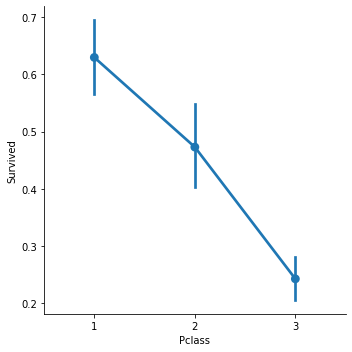

In [27]:
sns.factorplot('Pclass','Survived',order=[1,2,3], data=train_dt,size=5)

### Age: 

1. What is the distribution?

In [28]:
train_dt['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

2. How many missing or zero values?

In [29]:
train_dt['Age'].isnull().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [30]:
train_dt[train_dt['Age'] < 1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


2. What is distribution of age for those who survived and those who couldn't?

In [31]:
survived = train_dt[train_dt['Survived']==1]
died = train_dt[train_dt['Survived']==0]

In [32]:
survived = survived[survived['Age'].notnull()]
died = died[died['Age'].notnull()]

Text(0.5, 1.0, 'Age Distribution (Died)')

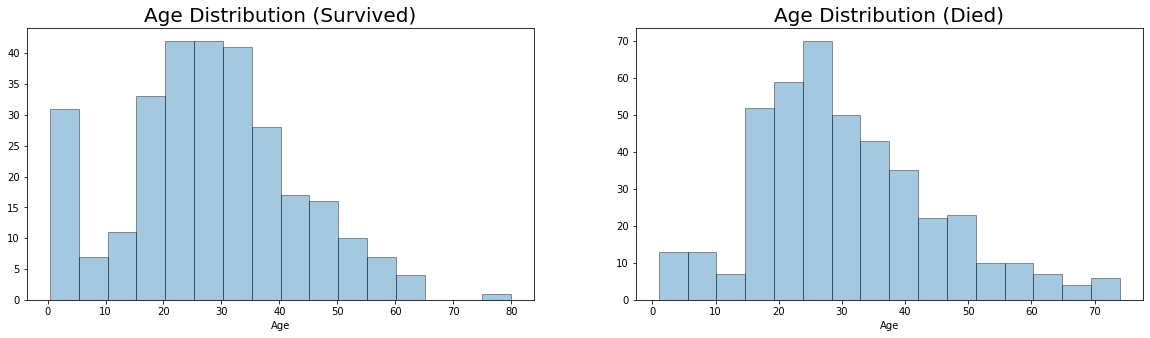

In [33]:
fig, ax = plt.subplots(figsize=(20,5), ncols=2)
sns.distplot(survived['Age'], kde=False, hist_kws={'edgecolor':'black'}, ax=ax[0])
ax[0].set_title('Age Distribution (Survived)',fontsize=20)
sns.distplot(died['Age'], kde=False, hist_kws={'edgecolor':'black'}, ax=ax[1])
ax[1].set_title('Age Distribution (Died)',fontsize=20)

3. Bucket Analysis:

In [34]:
temp = train_dt[train_dt['Age'].notnull()]

In [35]:
temp['Age_range'] = pd.cut(temp['Age'],[1,20,40,60,100])

/home/sehan/Documents/Jupyter-notebook/my_jupyter_notebook_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


4. Age, Pclass and Survival.

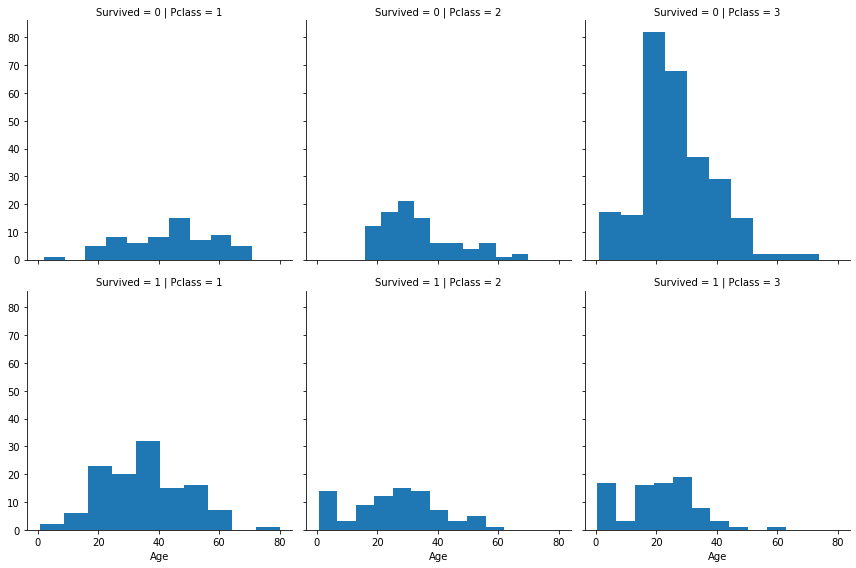

In [36]:
g = sns.FacetGrid(temp, col="Pclass",row='Survived',height=4)
g = g.map(plt.hist, "Age")

<div class='alert alert-block alert-info'>
    <p>Age distribition of each passenger class gives the following insights</p>
    <ol>
        <li>Aged people only survived in Pclass 1 </li>
        <li>Childrens survived in Pclass 2 and Pclass 3 </li>
        <li>People who have age less than 40 year had more survival chances in Pclass 3 </li>
        <li>In Pclass 2 all children survived</li>
   </ol>
</div>

5. Sex, Age and Survival.

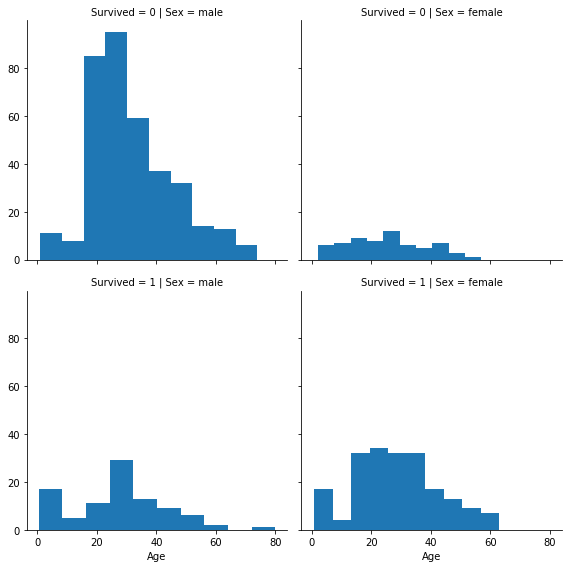

In [37]:
g = sns.FacetGrid(temp, col="Sex",row='Survived',height=4)
g = g.map(plt.hist, "Age")

6. Chisquare test for Age_range with Survival.

In [38]:
Age_rangeCrossTab = pd.crosstab(temp['Age_range'],temp['Survived'])

In [39]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(Age_rangeCrossTab)

In [40]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 3.1804575727612656 P-Value 0.3646302364909859


In [41]:
cramers_corrected_stat(train_dt,testStatistic,Age_rangeCrossTab)

0.05977919659927382

8. Boxplots of survived and died

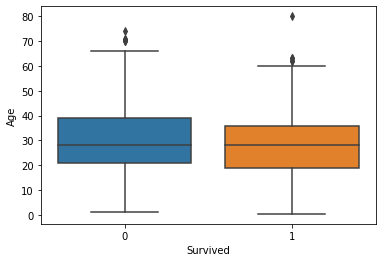

In [42]:
sns.boxplot(x='Survived',y='Age',data=temp)

In [43]:
temp.groupby(by=['Survived'])['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


9. Point Biserial Correlation Of age with Survival.

In [44]:
survived = temp[temp['Survived']==1]
died = temp[temp['Survived']==0]

Point Biserial from Scipy

In [45]:
pointbiserialr(temp['Age'],temp['Survived'])

PointbiserialrResult(correlation=-0.07722109457217767, pvalue=0.039124654013465966)

<div class='alert alert-block alert-info'>
    <p>After applying chi square, box plot analysis and Point biserial correlation it is confirm that age is not a significant predictor</p>
</div>

### Siblings and Spouse: 

1. What is the distribution? 

In [46]:
train_dt.groupby(by=['SibSp'])['PassengerId'].count()/len(train_dt)*100

SibSp
0    68.237935
1    23.456790
2     3.142536
3     1.795735
4     2.020202
5     0.561167
8     0.785634
Name: PassengerId, dtype: float64

1.1 What is the mean survival rate per level of this feature?

In [47]:
train_dt[['SibSp','Survived']].groupby(by=['SibSp']).mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


2. What is the survival percentage with respect to number of siblings or spouse on board?

In [48]:
train_dt[train_dt['Survived']==1].groupby(by=['SibSp'])['PassengerId'].count()/len(train_dt)*100

SibSp
0    23.569024
1    12.570146
2     1.459035
3     0.448934
4     0.336700
Name: PassengerId, dtype: float64

3. Barplot of Survival and SibSp

In [49]:
grp_dt = train_dt[['SibSp','Survived','PassengerId']].groupby(by=['SibSp','Survived']).count().reset_index()

Text(0, 0.5, 'Frequency')

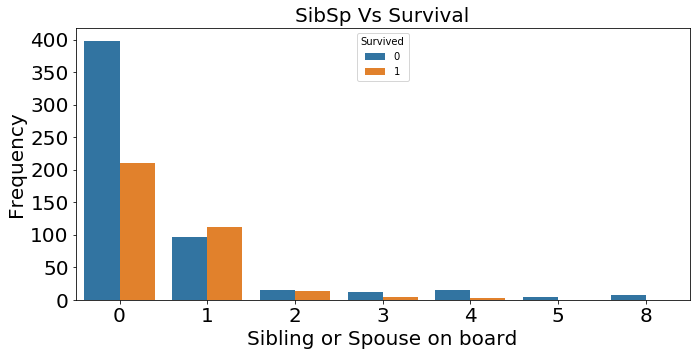

In [50]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x='SibSp',y='PassengerId',hue='Survived', data=grp_dt, ci=False)
ax.set_title('SibSp Vs Survival',fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('Sibling or Spouse on board', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

<div class='alert alert-block alert-info'>
    <p> It seems like Siblings or Spouse on board have some impact on survival. </p>
</div>

5. Coorelation of SibSp With Survival. 

In [51]:
SibSpCrossTab = pd.crosstab(train_dt['SibSp'],train_dt['Survived'])

In [52]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(SibSpCrossTab)

In [53]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 37.2717929152043 P-Value 1.5585810465902147e-06


In [54]:
cramers_corrected_stat(train_dt,testStatistic,SibSpCrossTab)

0.20464230226429342

<div class='alert alert-block alert-info'>
    <p>Crammer'V and chi square statistics confirm our assumption that SibSp can be deterministic but the correlation is very weak</p>
</div>

### Parents and Children: 

1. What is the distribution? 

In [55]:
train_dt.groupby(by=['Parch'])['PassengerId'].count()/len(train_dt)*100

Parch
0    76.094276
1    13.243547
2     8.978676
3     0.561167
4     0.448934
5     0.561167
6     0.112233
Name: PassengerId, dtype: float64

1.1 What is the mean survival rate per level of this feature?

In [56]:
train_dt[['Parch','Survived']].groupby(by=['Parch']).mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


2. What is the survival percentage with respect to number of parents or children  on board?

In [57]:
train_dt[train_dt['Survived']==1].groupby(by=['Parch'])['PassengerId'].count()/len(train_dt)*100

Parch
0    26.150393
1     7.295174
2     4.489338
3     0.336700
5     0.112233
Name: PassengerId, dtype: float64

3. Barplot of Survival and Parch 

In [58]:
grp_dt = train_dt[['Parch','Survived','PassengerId']].groupby(by=['Parch','Survived']).count().reset_index()

Text(0, 0.5, 'Frequency')

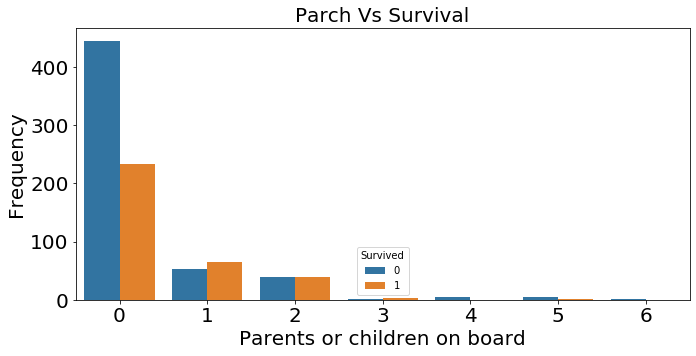

In [59]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x='Parch',y='PassengerId',hue='Survived', data=grp_dt, ci=False)
ax.set_title('Parch Vs Survival',fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('Parents or children on board', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

<div class='alert alert-block alert-info'>
    <p> It seems like Parents or Children on board have some impact on survival. </p>
</div>

5. Coorelation of SibSp With Survival. 

In [60]:
ParchCrossTab = pd.crosstab(train_dt['Parch'],train_dt['Survived'])

In [61]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(ParchCrossTab)

In [62]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 27.925784060236168 P-Value 9.703526421039997e-05


In [63]:
cramers_corrected_stat(train_dt,testStatistic,ParchCrossTab)

0.1771364589060439

<div class='alert alert-block alert-info'>
    <p>Crammer'V and chi square statistics confirm our assumption that Parch can be deterministic but the correlation is very weak</p>
</div>

Evaluated Features: Sex, Pclass, Age, SibSp, Parch 

### Fare: 

1. What is the distribution?

Text(0.5, 1.0, 'Fare Distribution')

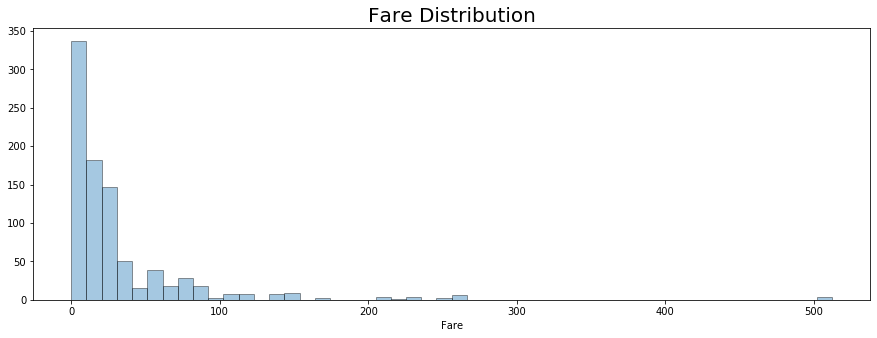

In [64]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(train_dt['Fare'], kde=False, hist_kws={'edgecolor':'Black'})
ax.set_title('Fare Distribution',fontsize=20)

2. What is the average fare? 

In [65]:
train_dt['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

3. How many instance in which fare is equal to zero?

In [66]:
train_dt[train_dt['Fare']<1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [67]:
print(len(train_dt[train_dt['Fare']<1]))

15


3.1 correcting fare in cases where it is less than 1. 

In [68]:
avg_fare = np.median(train_dt['Fare'])

In [69]:
train_dt['Fare'] = train_dt['Fare'].apply(lambda x: avg_fare if x < 1 else x )

4. How many instance in which fare is more than 31? 

In [70]:
high_fare = train_dt[train_dt['Fare'] > 31]

5. What is the percentage of suvival for people who paid high fare? 

In [71]:
(high_fare.groupby(by=['Survived'])['PassengerId'].count()/len(high_fare))*100

Survived
0    41.891892
1    58.108108
Name: PassengerId, dtype: float64

6. How many instance with fare less than or equals to 15 (median fare)?

In [72]:
avg_fare = train_dt[train_dt['Fare'] < 15]

7. What is the percentage of suvival for people who paid high fare? 

In [73]:
(avg_fare.groupby(by=['Survived'])['PassengerId'].count()/len(avg_fare))*100

Survived
0    75.054705
1    24.945295
Name: PassengerId, dtype: float64

8. Bucket Analysis of Fare

In [74]:
train_dt['Fare_buckets'] = pd.cut(train_dt['Fare'],[-1,8,15,32,520],labels=[25,50,75,100])

Text(0.5, 1.0, 'Survival Ratio with Fare Buckets')

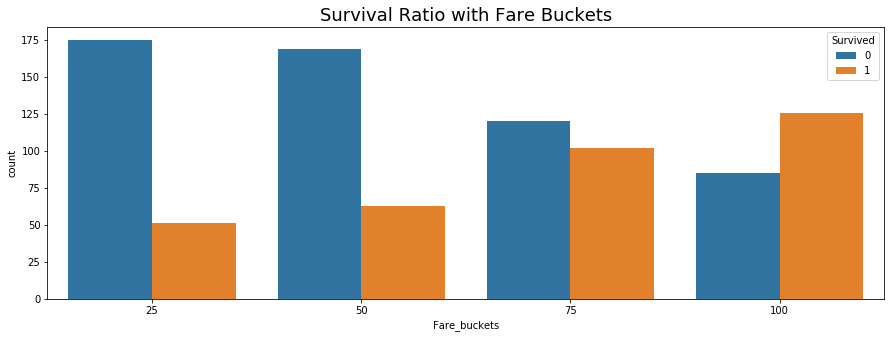

In [75]:
fig, ax = plt.subplots(figsize=(15,5))
sns.countplot(train_dt['Fare_buckets'],hue=train_dt['Survived'],ax=ax)
ax.set_title('Survival Ratio with Fare Buckets',fontsize=18)

<div class='alert alert-block alert-info'>
    <p>It seems like paying more can increase the chances of survival. Proper Coorelation will determine the impact of Fare on Survival</p>
</div>

9. Boxplot analysis of Fare. 

In [76]:
train_dt['Survived_trans'] = train_dt['Survived'].apply(lambda x: 'Survived' if x==1 else 'Died')

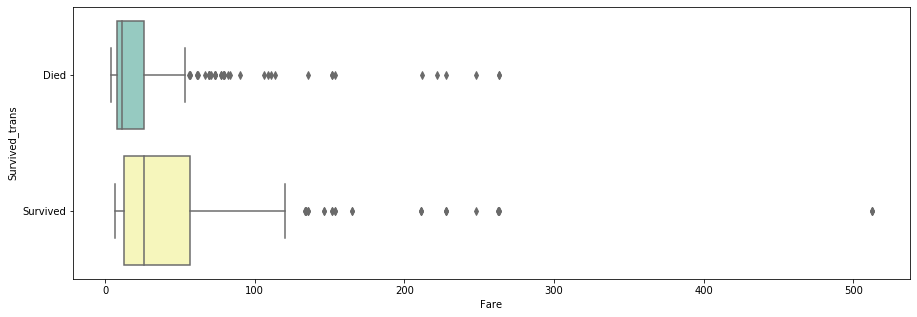

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(x=train_dt['Fare'],y=train_dt['Survived_trans'],ax=ax,palette="Set3")

10. Point Biserial Correlation

In [78]:
pointbiserialr(train_dt['Fare'],train_dt['Survived'])

PointbiserialrResult(correlation=0.2547426454565, pvalue=1.1539521501956347e-14)

12. Chisquare test for Fare_range with Survival.

In [79]:
Fare_buc_CrossTab = pd.crosstab(train_dt['Fare_buckets'],train_dt['Survived'])

In [80]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(Fare_buc_CrossTab)

In [81]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 82.24067272670501 P-Value 1.0146958386858673e-17


In [82]:
cramers_corrected_stat(train_dt,testStatistic,Fare_buc_CrossTab)

0.3039825108677112

### Embarked: 

1. Barplot of Embarked and Survival

In [83]:
grp_dt = train_dt[['Embarked','Survived','PassengerId']].groupby(by=['Embarked','Survived']).count().reset_index()

Text(0, 0.5, 'Frequency')

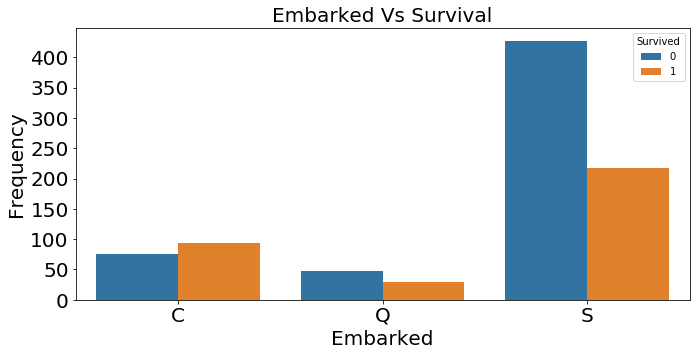

In [84]:
fig, ax = plt.subplots(figsize=(11,5))
sns.barplot(x='Embarked',y='PassengerId',hue='Survived', data=grp_dt, ci=False)
ax.set_title('Embarked Vs Survival',fontsize=20)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(20)
ax.set_xlabel('Embarked', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)

4. Coorelation of Embarked With Survival. 

In [85]:
EmbrkCrossTab = pd.crosstab(train_dt['Embarked'],train_dt['Survived'])

In [86]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(EmbrkCrossTab)

In [87]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 26.48914983923762 P-Value 1.769922284120912e-06


In [88]:
cramers_corrected_stat(train_dt,testStatistic,EmbrkCrossTab)

0.1725199329989738

<div class='alert alert-block alert-info'>
    <p>Crammer'V and Chi-square show very weak coorelation between Embarked and Survived</p>
</div>

5. How many records in which embark is missing? 

In [89]:
train_dt['Embarked'].notnull().value_counts()

True     889
False      2
Name: Embarked, dtype: int64

6. Replace missing with mode

In [90]:
replacement = train_dt['Embarked'].mode()

In [91]:
train_dt['Embarked'] = train_dt['Embarked'].fillna(value=replacement)

## Machine Learning # 01

In [92]:
X = pd.get_dummies(temp[['Sex','Pclass','SibSp','Parch','Embarked','Fare']])
X

,Pclass,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,1,0,7.2500,0,1,0,0,1
1,1,1,0,71.2833,1,0,1,0,0
2,3,0,0,7.9250,1,0,0,0,1
3,1,1,0,53.1000,1,0,0,0,1
4,3,0,0,8.0500,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
885,3,0,5,29.1250,1,0,0,1,0
886,2,0,0,13.0000,0,1,0,0,1
887,1,0,0,30.0000,1,0,0,0,1
889,1,0,0,30.0000,0,1,1,0,0


In [93]:
X = X[['Pclass', 'Sex_female','Sex_male','Embarked_C','Embarked_Q', 'Embarked_S']]
y = temp['Survived']

In [94]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y)

In [95]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train, Y_train, cv=20)
scores

array([0.77777778, 0.77777778, 0.66666667, 0.85185185, 0.74074074,
       0.7037037 , 0.77777778, 0.74074074, 0.77777778, 0.81481481,
       0.88888889, 0.81481481, 0.81481481, 0.77777778, 0.81481481,
       0.84615385, 0.73076923, 0.84615385, 0.96153846, 0.80769231])

In [96]:
np.average(scores)*100

79.66524216524216

In [97]:
clf.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [99]:
Y_pred = clf.predict(X_test)

In [100]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.72      0.98      0.83       100
           1       0.95      0.52      0.67        79

    accuracy                           0.78       179
   macro avg       0.84      0.75      0.75       179
weighted avg       0.82      0.78      0.76       179



In [101]:
accuracy_score(Y_test,Y_pred)*100

77.6536312849162

In [102]:
precision_score(Y_test,Y_pred, labels=[0,1])*100

95.34883720930233

In [103]:
recall_score(Y_test,Y_pred, labels=[0,1])*100

51.89873417721519

In [104]:
tn,fp,fn,tp = confusion_matrix(Y_test,Y_pred,labels=[0,1]).ravel()

In [105]:
confusion_matrix(Y_pred,Y_test,labels=[0,1])

array([[98, 38],
       [ 2, 41]])

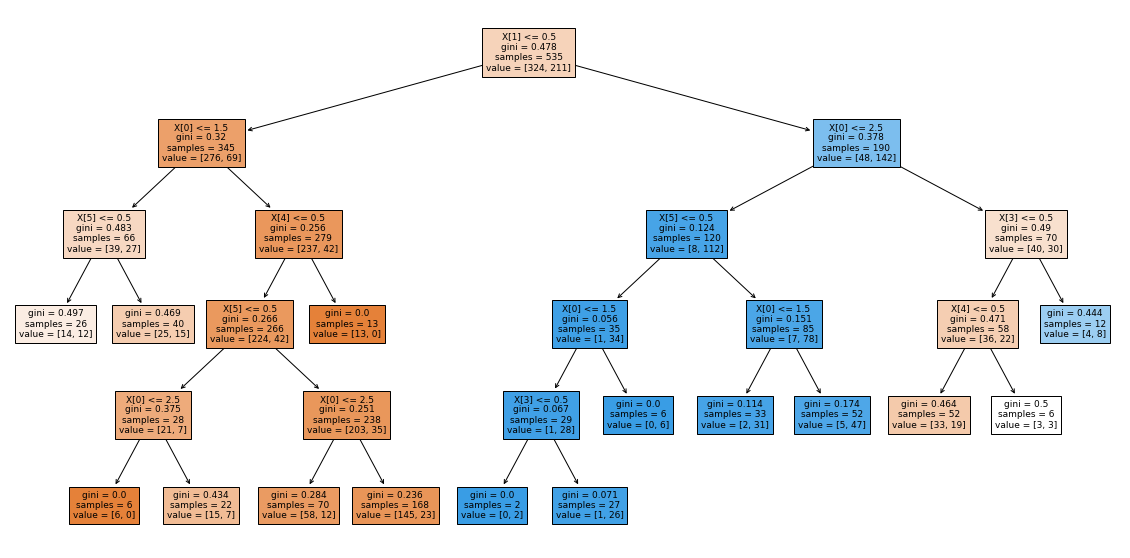

In [108]:
plt.figure(figsize=(20,10))
plot_tree(clf,fontsize=9,filled=True)
plt.show()

# Feature Engineering:

## Feature Selection using Embedded Method: 

In [109]:
pd.DataFrame({'features': X_train.columns,'imp':clf.feature_importances_*100}).sort_values(by=['imp'],ascending=False)

,features,imp
1,Sex_female,68.240205
0,Pclass,28.627048
3,Embarked_C,1.530959
5,Embarked_S,0.846175
4,Embarked_Q,0.755613
2,Sex_male,0.000000


## Feature Construction

## 1. Family Size:

In [110]:
train_dt['Family_size'] = train_dt['SibSp'] + train_dt['Parch'] + 1

1. What is the mean survival rate per level of this feature ?

In [111]:
train_dt[['Family_size','Survived']].groupby(by=['Family_size']).mean()

,Survived
Family_size,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


2. What is the association of family size with outcome?

In [112]:
FamilyCrossTab = pd.crosstab(train_dt['Family_size'],train_dt['Survived'])

In [113]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(FamilyCrossTab)

In [114]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 80.67231343783078 P-Value 3.579668975443533e-14


In [115]:
cramers_corrected_stat(train_dt,testStatistic,FamilyCrossTab)

0.30107003045893016

## 3. Is_Alone:

In [116]:
train_dt['Is_alone'] = train_dt['Family_size'].apply(lambda x: 1 if x==1 else 0 )

1. What is the mean survival rate per level of this feature ?

In [117]:
train_dt[['Survived','Is_alone']].groupby(by=['Is_alone']).mean()

,Survived
Is_alone,
0,0.505650
1,0.303538


2. What is the association of is alone with outcome?

In [118]:
IsAloneCrossTab = pd.crosstab(train_dt['Is_alone'],train_dt['Survived'])

In [119]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(IsAloneCrossTab)

In [120]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 36.00051446773865 P-Value 1.9726543846517113e-09


In [121]:
cramers_corrected_stat(train_dt,testStatistic,IsAloneCrossTab)

0.20112202097919463

## 3. Family Type: 

In [122]:
train_dt['Family_type'] = train_dt['Family_size'].apply(lambda x: 1 if x==1 else 2 if x ==2  else 3 
                                                        if x <=4 else 5)

In [123]:
train_dt['Family_type'].value_counts()

1    537
2    161
3    131
5     62
Name: Family_type, dtype: int64

1. What is the mean survival rate per level?

In [124]:
train_dt[['Family_type','Survived']].groupby(by=['Family_type']).mean()

,Survived
Family_type,
1,0.303538
2,0.552795
3,0.610687
5,0.161290


2. What is the association of family type with outcome?

In [125]:
FamilyTCrossTab = pd.crosstab(train_dt['Family_type'],train_dt['Survived'])

In [126]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(FamilyTCrossTab)

In [127]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 75.56079716081948 P-Value 2.747307908074899e-16


In [128]:
cramers_corrected_stat(train_dt,testStatistic,FamilyTCrossTab)

0.29137583852147453

## 4. Title: 

1. Creation of Title:

In [129]:
train_dt['Title'] = train_dt['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()

In [130]:
train_dt['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

1.1 Make it standard. 

In [131]:
train_dt['Title'] = train_dt['Title'].replace(['Don', 'Rev', 'Dr', 'Mme', 'Ms','Major', 'Lady', 'Sir', 'Mlle', 'Col', 
                           'Capt', 'the Countess','Jonkheer'],'Rare')

In [132]:
train_dt['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64

2. Percentage of each title. (overall) 

In [133]:
round(train_dt['Title'].value_counts()/len(train_dt)*100)

Mr        58.0
Miss      20.0
Mrs       14.0
Master     4.0
Rare       3.0
Name: Title, dtype: float64

3. Percentage of each title (Survival)

In [134]:
survived = train_dt[train_dt['Survived']==1]

In [135]:
round(survived['Title'].value_counts()/len(survived)*100)

Miss      37.0
Mrs       29.0
Mr        24.0
Master     7.0
Rare       4.0
Name: Title, dtype: float64

4. Mean of survival per title.

In [136]:
train_dt[['Title','Survived']].groupby(by=['Title']).mean().sort_values(by=['Survived'],ascending=False)

,Survived
Title,
Mrs,0.792000
Miss,0.697802
Master,0.575000
Rare,0.444444
Mr,0.156673


5. What is the association of Title with Survival ?

In [137]:
TitleCrossTab = pd.crosstab(train_dt['Title'],train_dt['Survived'])

In [138]:
testStatistic, pVal, dof, contigencyTab = chi2_contingency(TitleCrossTab)

In [139]:
print('Test Statistics', testStatistic, 'P-Value',pVal)

Test Statistics 283.3115089621979 P-Value 4.305036064730923e-60


In [140]:
cramers_corrected_stat(train_dt,testStatistic,TitleCrossTab)

0.5642055831328221

6. Transform title for algorithm

In [141]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

In [142]:
train_dt['Title'] = train_dt['Title'].map(title_mapping)

In [143]:
train_dt['Title'].value_counts()

1    517
2    182
3    125
4     40
5     27
Name: Title, dtype: int64

In [144]:
X = pd.get_dummies(train_dt[['Pclass','Fare_buckets','Embarked','Is_alone','Title','Sex']])
X

,Pclass,Is_alone,Title,Fare_buckets_25,Fare_buckets_50,Fare_buckets_75,Fare_buckets_100,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,3,0,1,1,0,0,0,0,0,1,0,1
1,1,0,3,0,0,0,1,1,0,0,1,0
2,3,1,2,1,0,0,0,0,0,1,1,0
3,1,0,3,0,0,0,1,0,0,1,1,0
4,3,1,1,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,1,5,0,1,0,0,0,0,1,0,1
887,1,1,2,0,0,1,0,0,0,1,1,0
888,3,0,2,0,0,1,0,0,0,1,1,0
889,1,1,1,0,0,1,0,1,0,0,0,1


In [145]:
X = X.drop(['Sex_male'],axis=1)

In [146]:
y = train_dt['Survived']

In [147]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y)

In [148]:
clf = DecisionTreeClassifier()
scores = cross_val_score(clf, X_train, Y_train, cv=20)
scores*100

array([73.52941176, 76.47058824, 73.52941176, 70.58823529, 82.35294118,
       88.23529412, 85.29411765, 79.41176471, 78.78787879, 72.72727273,
       78.78787879, 87.87878788, 78.78787879, 72.72727273, 84.84848485,
       72.72727273, 78.78787879, 75.75757576, 78.78787879, 78.78787879])

In [149]:
np.average(scores)*100

78.44028520499108

In [150]:
decision_tree = DecisionTreeClassifier(splitter="best", max_depth=8).fit(X_train,Y_train)

In [151]:
Y_pred = decision_tree.predict(X_test)

In [152]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.86       132
           1       0.85      0.70      0.77        91

    accuracy                           0.83       223
   macro avg       0.84      0.81      0.82       223
weighted avg       0.83      0.83      0.83       223



In [153]:
accuracy_score(Y_test,Y_pred)*100

82.95964125560538

In [154]:
precision_score(Y_test,Y_pred, labels=[0,1])*100

85.33333333333334

In [155]:
recall_score(Y_test,Y_pred, labels=[0,1])*100

70.32967032967034

In [156]:
tn,fp,fn,tp = confusion_matrix(Y_test,Y_pred,labels=[0,1]).ravel()

In [157]:
confusion_matrix(Y_pred,Y_test,labels=[0,1])

array([[121,  27],
       [ 11,  64]])